## Abstract

 This paper aims to apply a Machine Learning classifier to Mexican Death records in other to improve classification. 

In [1]:
import pandas as pd
import numpy as np
import re, string, os, torch, nltk, itertools, spacy
from unidecode import unidecode
from tqdm import tqdm 
tqdm.pandas()

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, GRU, Bidirectional,Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, legacy
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend as K
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, RobertaTokenizer, DistilBertTokenizer
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, DistilBertForSequenceClassification
from transformers import AdamW, get_scheduler

from spellchecker import SpellChecker
from functools import lru_cache

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

pd.set_option('display.max_colwidth', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Helpers functions

In [2]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, using CPU instead.")


1 Physical GPUs, 1 Logical GPU


2024-08-14 11:17:17.576377: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-14 11:17:17.576426: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-08-14 11:17:17.576433: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-08-14 11:17:17.576511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-14 11:17:17.576705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Read data

In [3]:
#Access data
def read_file(path):
  """
  Access and filter data, parameters are:
  ---------------------------
    - path: file to access data
    - columnas: selected columns for analysis 
    - base: year of dataset 
  """
  columnas = ['base','sexo','edad','res_ent','des_causa_a','causa_a', 
            'des_causa_b','causa_b','des_causa_c','causa_c']
  
  df = pd.read_pickle(path)[columnas]
  df = df[df.base == 2021]
  for x in df.columns:
    if x in df.select_dtypes(include = 'category').columns:
      df[x] = df[x].astype(str).str.lower()

  #In labels count the number of codes related diagnosis 
  def count_words(causa):
    """
    causa: refers to ICD code, sometimes more than 1 code is assigned 
    """
    if isinstance(causa, str):
      return len(causa.split())
    return 0
  
  len_causa = []
  for causa in ['causa_a','causa_b','causa_c']:
    df[f'{causa}_word_count'] = df[causa].apply(count_words)
    len_causa.append(f'{causa}_word_count')  
  #filtered_df = df[df[len_causa].apply(lambda x: any(x == 1), axis=1)]
  """categories 888 and 999 were assigned for newborns or under 1 year old """
  df['edad'] = df['edad'].replace({888:0, 999:0})

  return df

#In this section we melt 
def merge_data(data):
  row1 = data.melt(
  id_vars = ['base','sexo','edad','res_ent'],
  value_vars=["des_causa_a", "des_causa_b", "des_causa_c"], 
  var_name="causa_type", 
  value_name="causa")
  
  row2 = data.melt(
  id_vars = ['base','sexo','edad','res_ent'],
  value_vars = ['causa_a','causa_b','causa_c'],
  var_name='causa_code',
  value_name = 'causa_icd')
  merged_data = pd.concat([row1.drop('causa_type', axis=1),
                    row2[['causa_icd']]], axis=1)
  return merged_data

def clean_causa_icd(df):
    """
    Clean and filter the 'causa_icd' column in the dataframe.
    """
    def removechar(text):
      if isinstance(text, str):
        text = text.lower()
        text = unidecode(text)
        punctuation = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''
        text = text.translate(str.maketrans('', '', punctuation))
        text = re.sub(r'-','', text)
        text = text.strip()
        return text
      return None
  
    df['causa_icd'] = df['causa_icd'].apply(removechar).str.strip().str.replace('[^\x00-\x7F]', '', regex=True)
    df = df[df['causa_icd'].notna() & df['causa_icd'].str.match(r'^[a-zA-Z]\d{3}$|^[a-zA-Z]\d{2}[a-zA-Z]$')]
    df = df[df['causa_icd'].isin(df.causa_icd.value_counts()[:20].index)]
    df['sexo'] = df['sexo'].replace({0:float(np.nan), 
                                     9:float(np.nan)})
    df['res_ent'] = df['res_ent'].replace({0:float(np.nan),
                                           88:float(np.nan),
                                           99:float(np.nan)})
    df = df[pd.Series(df['sexo']).astype(float).notna()]
    df = df[pd.Series(df['res_ent']).astype(float).notna()]
    df = df.drop(columns = ['base'], axis=1)
        
    return df

nlp = spacy.load('es_core_news_md')

def clean_description(text):
  if not isinstance(text, str):
    return ""
  text = unidecode(text.lower().strip())
  punctuation = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''
  text = text.translate(str.maketrans('', '', punctuation))
  words = word_tokenize(text)
  spanish_stopwords = set(stopwords.words('spanish'))
  filtered_words = [word for word in words if word not in spanish_stopwords]
  filtered_text = ' '.join(filtered_words)
  doc = nlp(filtered_text)
  lemmatized_words = ' '.join(token.lemma_ for token in doc)
  
  return lemmatized_words

# Initialize SpellChecker once
spell = SpellChecker(language='es')
custom_words = {"covid", "sars", "cov", "sars-cov2", "covid19"}
spell.word_frequency.load_words(custom_words)

# Cache corrected words
@lru_cache(maxsize=10000)
def correct_word(word):
    if word in custom_words:
        return word
    return spell.correction(word) or word

def spellcheck_correction(text):
    words = text.split()
    corrected_words = [correct_word(word) for word in words]
    return ' '.join(corrected_words)

# Define the remove_digits function
def remove_digits(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text

## 1. Description of the dataset

In [86]:
path = '../Data/icd_mexico.pkl' ## access to data
data = pd.read_pickle(path) ## Read dataset
data = data[data.base <2022]

In [87]:
demographic = ['sexo', 'edad', 'res_ent','def_ent']
icd_causa = ['causa_bas', 'causa_a','causa_b','causa_c','causa_d']
icd_description = ['des_causa_a','des_causa_b','des_causa_C']
data.loc[:,'sexo'] = data['sexo'].replace({1:'Male', 2:'Female', 0:np.nan, 9:np.nan})

### A. Series


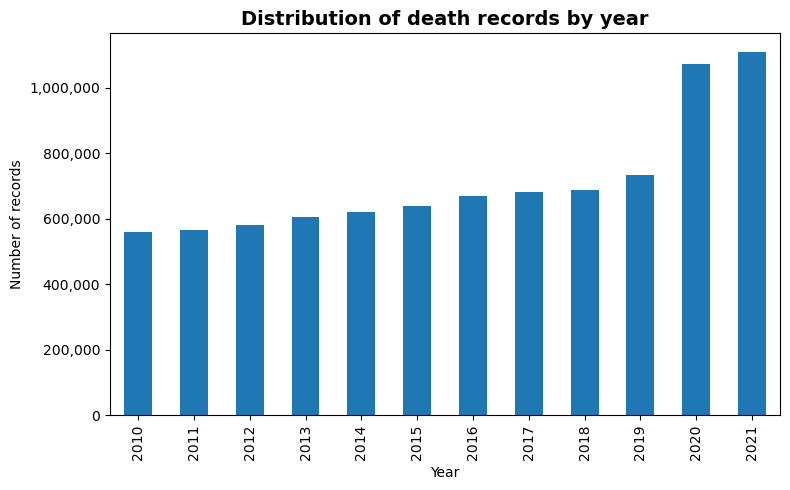

In [88]:
def format_func(value, tick_number):
    return f'{int(value):,}'

fig, ax = plt.subplots(figsize = (8, 5))
data['base'].value_counts().sort_index().plot(kind = 'bar', ax = ax)
ax.set_title('Distribution of death records by year', fontsize = 14, weight = "bold")
ax.set_xlabel('Year', fontsize = 10)
ax.set_ylabel('Number of records', fontsize = 10)
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
plt.tight_layout()
plt.show()

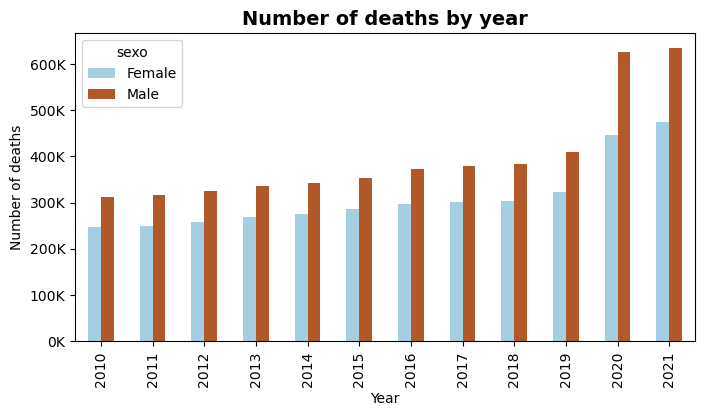

In [89]:
## Number of deaths by year and sex
fig, ax = plt.subplots(figsize = (8, 4))
counts = (data[['base','sexo']]
          .groupby(['base','sexo']).base.count().unstack()
          .plot(kind='bar',stacked = False, colormap = 'Paired', ax = ax))

formatter = FuncFormatter(lambda x, pos: f'{int(x/1000)}K')
ax.yaxis.set_major_formatter(formatter)

plt.xlabel ('Year')
plt.ylabel ('Number of deaths')

plt.title('Number of deaths by year',
          fontsize=14, weight = 'bold')
plt.show()

In [116]:
bins = [-1, 0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129]
labels = ['<0', '1-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100-104', '105-109', '110-114', '115-119', '120-124', '125-129']
data['age_group'] = pd.cut(data['edad'].replace({888: np.nan, 999: np.nan}), bins=bins, labels=labels, right=True)
pyramid = data[['age_group', 'sexo']].groupby(['age_group','sexo']).sexo.count().unstack().reset_index()
age, female, female = pyramid['age_group'], pyramid['Female'], pyramid['Male']
# pyramid["Female_Left"] = 0
# pyramid["Female_Width"] = pyramid["Female"]

# pyramid["Male_Left"] = -pyramid["Male"]
# pyramid["Male_Width"] = pyramid["Male"]
pyramid

sexo,age_group,Female,Male
0,<0,431,527
1,1-4,89822,115470
2,5-9,43264,53551
3,10-14,29401,38951
4,15-19,36611,83209
5,20-24,42733,128995
6,25-29,45707,140769
7,30-34,50440,147050
8,35-39,66898,169368
9,40-44,93078,200750


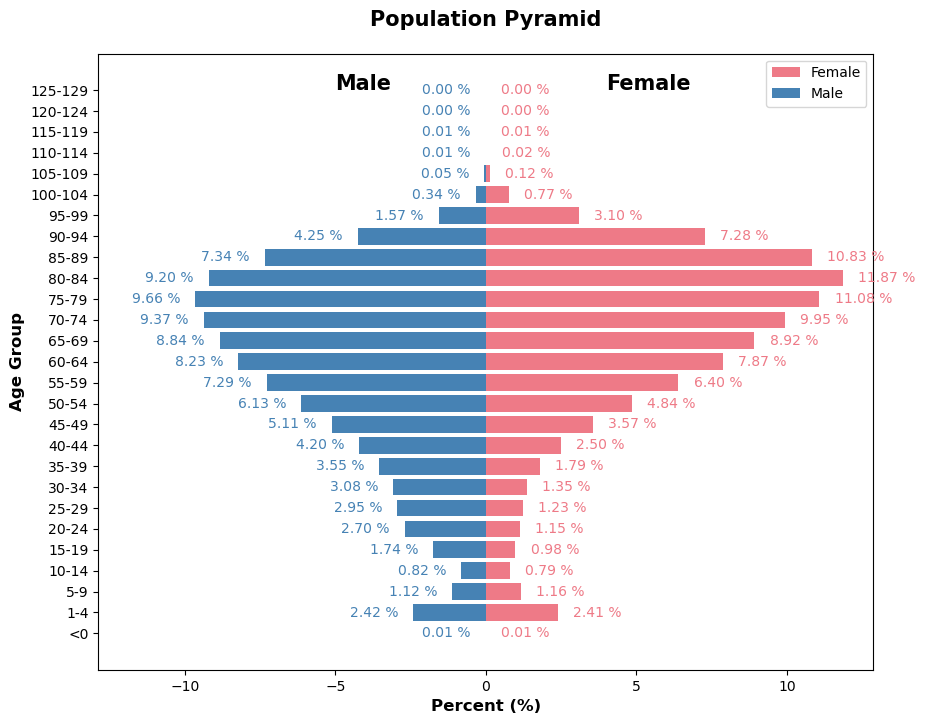

In [117]:
# Calculate the width and left positions for the bars
pyramid['Female_Width'] = pyramid['Female'] / sum(pyramid['Female']) * 100
pyramid['Male_Width'] = pyramid['Male'] / sum(pyramid['Male']) * 100
pyramid['Male_Left'] = -pyramid['Male_Width']

# Plotting the population pyramid
female_color = "#ee7a87"
male_color = "#4682b4"

fig = plt.figure(figsize=(10, 8))

plt.barh(y=pyramid["age_group"], width=pyramid["Female_Width"], color=female_color, label="Female")
plt.barh(y=pyramid["age_group"], width=pyramid["Male_Width"], left=pyramid["Male_Left"], color=male_color, label="Male")

plt.text(-5, len(pyramid) - 1, "Male", fontsize=15, fontweight="bold")
plt.text(4, len(pyramid) - 1, "Female", fontsize=15, fontweight="bold")

for idx in range(len(pyramid)):
    plt.text(x=pyramid["Male_Left"][idx] - 0.5, y=idx, s="{:.2f} %".format(pyramid["Male_Width"][idx]),
             ha="right", va="center", fontsize=10, color=male_color)
    plt.text(x=pyramid["Female_Width"][idx] + 0.5, y=idx, s="{:.2f} %".format(pyramid["Female_Width"][idx]),
             ha="left", va="center", fontsize=10, color=female_color)

plt.xlim(-max(pyramid["Male_Width"].max(), pyramid["Female_Width"].max()) - 1, 
          max(pyramid["Male_Width"].max(), pyramid["Female_Width"].max()) + 1)

plt.xlabel("Percent (%)", fontsize=12, fontweight="bold")
plt.ylabel("Age Group", fontsize=12, fontweight="bold")
plt.title("Population Pyramid", loc="center", pad=20, fontsize=15, fontweight="bold")
plt.legend(loc="upper right")

plt.show()


In [111]:
# Check for extreme values in the relevant columns
print(pyramid["Male_Left"].max(), pyramid["Male_Left"].min())
print(pyramid["Male_Width"].max(), pyramid["Male_Width"].min())
print(pyramid["Female_Width"].max(), pyramid["Female_Width"].min())


-1 -461347
461347 1
442556 1


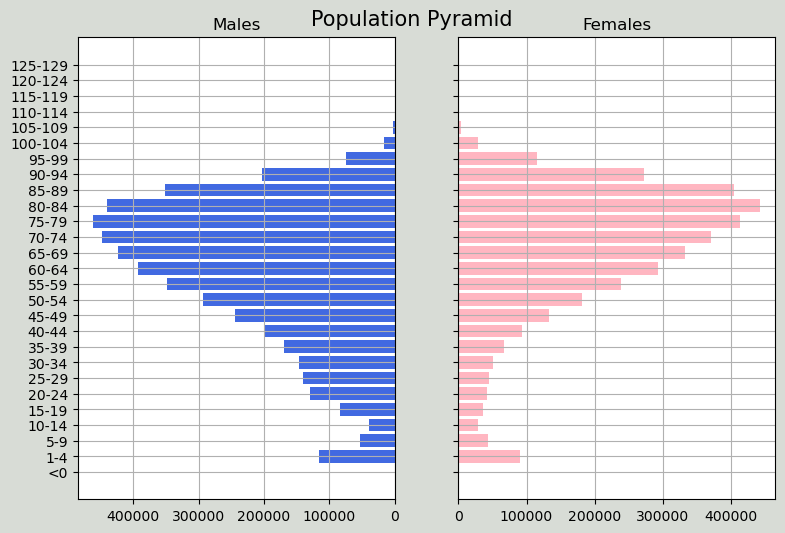

In [100]:
#define x and y limits
y = range(0, len(pyramid))
x_male = pyramid['Male']
x_female = pyramid['Female']

#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 6))

#specify background color and plot title
fig.patch.set_facecolor('xkcd:light grey')
plt.figtext(.5,.9,"Population Pyramid ", fontsize=15, ha='center')
    
#define male and female bars
axes[0].barh(y, x_male, align='center', color='royalblue')
axes[0].set(title='Males')
axes[1].barh(y, x_female, align='center', color='lightpink')
axes[1].set(title='Females')

#adjust grid parameters and specify labels for y-axis
axes[1].grid()
axes[0].set(yticks=y, yticklabels=pyramid['age_group'])
axes[0].invert_xaxis()
axes[0].grid()

#display plot
plt.show()

In [ ]:

# Grouping and counting occurrences
grouped_data = data.groupby(['base', 'sexo']).size()

# Plotting
ax = grouped_data.unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightgreen'])

# Adding title and labels
plt.title('Count of Base by Sexo', fontsize=14)
plt.xlabel('Base', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotating x-axis labels
plt.xticks(rotation=45, ha='right')

# Adding a legend
plt.legend(title='Sexo')

# Display the plot
plt.tight_layout()
plt.show()


### B. Sex

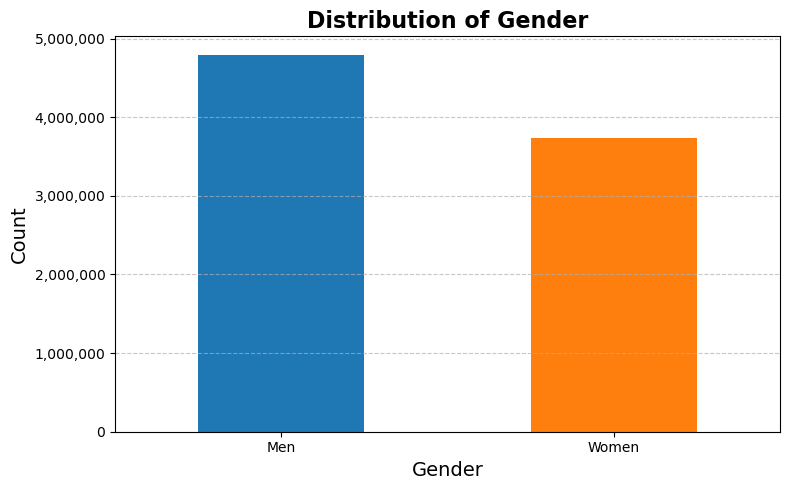

In [36]:

def format_func(value, tick_number):
    return f'{int(value):,}'

fig, ax = plt.subplots(figsize=(8,5))  
data['sexo'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'], ax=ax)
ax.set_title('Distribution of Gender', fontsize=16, weight='bold')
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
plt.tight_layout()
plt.show()

## 2. Data pre-processing 

In [ ]:
df = clean_causa_icd(merge_data(read_file(path)))

df['causa'] = df['causa'].progress_apply(clean_description)
df['sexo'] = df.sexo.astype(int)
df['cause'] = df.loc[:,['sexo','edad','causa']].progress_apply(lambda x: ' '.join(x.astype(str)), axis=1)
df['causa'] = df['causa'].progress_apply(remove_digits).progress_apply(spellcheck_correction)
df['len_causa'] = df['causa'].apply(lambda x: len(x.split()))

In [19]:
df.len_causa.value_counts()

len_causa
3     787405
2     490212
4     116345
1      82778
5      18749
6       3892
0       1788
7        478
8        118
9         16
10        12
15         4
12         3
11         3
14         2
13         1
Name: count, dtype: int64

In [20]:
df[["causa","causa_icd"]]

,causa,causa_icd
2,insuficiencia respiratorio agudo,j960
12,infarto agudo miocardio,i219
17,insuficiencia cardiaco,i509
29,infarto agudo miocardio,i219
37,infarto agudo miocardio,i219
...,...,...
3331079,hipertensión arterial,i10x
3331348,covid virus identificar,u072
3331449,probable sars cov,u072
3331893,covid virus identificar,u071


## 3. Classifier

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Encode the labels
label_map = {label: idx for idx, label in enumerate(df['causa_icd'].unique())}
df['label'] = df['causa_icd'].map(label_map)

In [9]:
# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(df['causa'].tolist(), df['label'].tolist(), test_size=0.2)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


In [10]:
# Create a PyTorch Dataset
class ICD10Dataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ICD10Dataset(train_encodings, train_labels)
val_dataset = ICD10Dataset(val_encodings, val_labels)

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/225273 [00:00<?, ?it/s]

{'loss': 3.1125, 'grad_norm': 5.856096267700195, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 3.1071, 'grad_norm': 7.194703102111816, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0}
{'loss': 3.052, 'grad_norm': 7.192967414855957, 'learning_rate': 3e-06, 'epoch': 0.0}
{'loss': 2.9343, 'grad_norm': 6.876082420349121, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.0}
{'loss': 2.8835, 'grad_norm': 15.499566078186035, 'learning_rate': 5e-06, 'epoch': 0.0}
{'loss': 2.8125, 'grad_norm': 13.784601211547852, 'learning_rate': 6e-06, 'epoch': 0.0}
{'loss': 2.7506, 'grad_norm': 7.916377544403076, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.0}
{'loss': 2.5674, 'grad_norm': 7.1779704093933105, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.0}
{'loss': 2.3283, 'grad_norm': 8.958433151245117, 'learning_rate': 9e-06, 'epoch': 0.0}
{'loss': 2.2359, 'grad_norm': 6.167052745819092, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 2.1014, 'grad_norm': 13.2033996582031

KeyboardInterrupt: 

In [9]:
vocabulary = set()

for word in df['causa']:
  words = word.split()
  vocabulary.update(words)

voc = sorted(vocabulary)  

In [15]:
df[df['causa'] == 'infarto agudo miocardio']

,sexo,edad,res_ent,causa,causa_icd,cause
12,1,0,16.0,infarto agudo miocardio,i219,1 0 infarto agudo almiocardio
29,1,0,4.0,infarto agudo miocardio,i219,1 0 infarto agudo miocardio
37,1,0,21.0,infarto agudo miocardio,i219,1 0 infarto agudo miocardio
49,1,0,21.0,infarto agudo miocardio,i219,1 0 infarto agudo miocardio
50,1,0,6.0,infarto agudo miocardio,i219,1 0 infarto agudo miocardio
...,...,...,...,...,...,...
3326744,2,101,16.0,infarto agudo miocardio,i219,2 101 infarto agudo miocardio
3328837,2,104,16.0,infarto agudo miocardio,i219,2 104 infarto agudo miocardio
3329410,2,106,9.0,infarto agudo miocardio,i219,2 106 infarto agudo miocardio
3329541,1,107,12.0,infarto agudo miocardio,i219,1 107 infarto agudo miocardio


Access Catalogo cie

In [30]:
def read_catalogue(row):
  columnas = ['CATALOG_KEY', 'DIA_NOMBRE']
  df = pd.read_excel(path, usecols = columnas)
  df = df.apply(lambda x: x.str.lower())
  df.columns = df.columns.str.lower()
  df = df.rename(
    columns = {'catalog_key':'cie','dia_nombre':'descripcion'})
  df = df[~df.cie.isin(df.cie.str[:3])]
  return df

path = '/Users/pierredelice/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/EM_FellegiSunter/data/CATALOGO_CIE_10_PRODUCCION_29042022.xlsx'
catalogue = read_catalogue(path)

In [35]:
len(catalogue)

12674

In [56]:
set(catalogue[catalogue['cie'].isin(df['causa_icd'].value_counts().index)].descripcion)

{'acidosis',
 'choque cardiogénico',
 'choque hipovolémico',
 'choque séptico',
 'covid-19, virus identificado',
 'covid-19, virus no identificado',
 'diabetes mellitus no especificada, sin mención de complicación',
 'diabetes mellitus tipo 2, sin mención de complicación',
 'enfermedad renal crónica, no especificada',
 'hipertensión esencial (primaria)',
 'infarto agudo del miocardio, sin otra especificación',
 'insuficiencia cardíaca, no especificada',
 'insuficiencia renal no especificada',
 'insuficiencia respiratoria aguda',
 'insuficiencia respiratoria, no especificada',
 'neumonía debida a otros virus',
 'neumonía, no especificada',
 'otros síntomas y signos generales especificados',
 'paro cardíaco, no especificado',
 'síndrome de dificultad respiratoria del adulto'}

In [20]:
df["causa_3d"] = df['causa_icd'].str[:3]

<Axes: xlabel='causa_3d'>

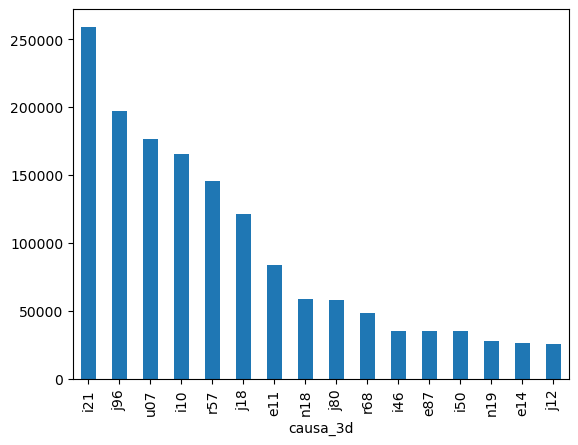

In [29]:
df.causa_3d.value_counts().sort_values(ascending = False).plot(kind='bar')

<Axes: xlabel='causa_icd'>

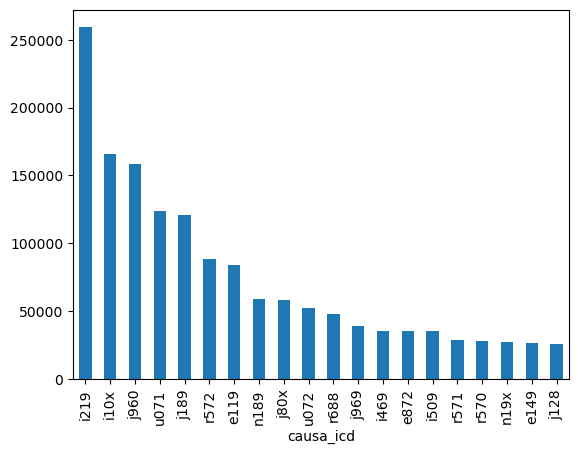

In [28]:
df.causa_icd.value_counts().sort_values(ascending=False).plot(kind='bar')

In [59]:
df.head()

,sexo,edad,res_ent,causa,causa_icd,cause,causa_3d
2,1,0,21.0,insuficiencia respiratorio agudo,j960,1 0 insuficiencia respiratorio agudo,j96
12,1,0,16.0,infarto agudo almiocardio,i219,1 0 infarto agudo almiocardio,i21
17,1,0,32.0,insuficiencia cardiaco,i509,1 0 insuficiencia cardiaco,i50
29,1,0,4.0,infarto agudo miocardio,i219,1 0 infarto agudo miocardio,i21
37,1,0,21.0,infarto agudo miocardio,i219,1 0 infarto agudo miocardio,i21


In [72]:
index = pd.Index(df.causa_icd.value_counts().index.sort_values())
label_dict = {value: idx for idx, value in enumerate(index)}
df['label'] = df['causa_icd'].map(label_dict)

In [73]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
NUM_CLASSES = len(df.causa_icd.value_counts().index)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = NUM_CLASSES)
text, labels = df['causa'].tolist(), df['label'].tolist()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import torch
import torch.nn.functional as F

# Example encoder output (batch_size=1, seq_len=5, hidden_dim=10)
encoder_outputs = torch.randn(1, 5, 10)
# Example decoder hidden state (batch_size=1, hidden_dim=10)
decoder_hidden = torch.randn(1, 10)

# Calculate attention scores (dot product)
attention_scores = torch.bmm(encoder_outputs, decoder_hidden.unsqueeze(2)).squeeze(2)

# Apply softmax to get attention weights
attention_weights = F.softmax(attention_scores, dim=1)

# Compute context vector as weighted sum of encoder outputs
context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

print("Attention Weights:", attention_weights)
print("Context Vector:", context_vector)


Attention Weights: tensor([[0.4315, 0.0015, 0.0505, 0.0684, 0.4481]])
Context Vector: tensor([[ 0.7471,  0.6254, -1.3010, -0.5672,  2.0783, -0.0898,  0.2919, -0.7535,
          0.0389, -0.2095]])


In [14]:
tokens = ["El", "paciente", "tuvo", "un", "paro", "cardiaco", "que", "le", "implicó", "la", "muerte"]


In [15]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode the sentence
input_ids = tokenizer.encode("El paciente tuvo un paro cardiaco que le implicó la muerte", return_tensors='pt')
outputs = model(input_ids)

# Extract the hidden states (last layer)
hidden_states = outputs.last_hidden_state


In [16]:
# Define a query vector, possibly initialized randomly or trained
query_vector = torch.randn(hidden_states.size(-1))

# Compute attention scores as dot product between query and hidden states
attention_scores = torch.matmul(hidden_states, query_vector)

# Apply softmax to get attention weights
attention_weights = torch.nn.functional.softmax(attention_scores, dim=1)

# Compute context vector as the weighted sum of hidden states
context_vector = torch.matmul(attention_weights.unsqueeze(0), hidden_states)

print("Attention Weights:", attention_weights)
print("Context Vector:", context_vector)


Attention Weights: tensor([[1.3045e-04, 1.9722e-11, 1.3394e-08, 9.3723e-12, 5.3609e-01, 5.6384e-10,
         3.4508e-13, 7.6840e-13, 3.1875e-07, 2.0298e-01, 6.7735e-08, 2.4038e-14,
         1.5815e-12, 1.8501e-05, 2.1381e-05, 8.9027e-03, 9.3864e-05, 2.3971e-01,
         5.3530e-05, 1.1996e-02, 2.1095e-22]], grad_fn=<SoftmaxBackward0>)
Context Vector: tensor([[[-1.6007e-01, -3.5172e-02, -2.1596e-02,  4.8788e-02,  1.1592e-01,
           1.2787e+00,  7.6812e-01,  1.6938e+00,  6.0624e-01, -6.0705e-01,
          -2.6530e-01,  3.1308e-01,  1.9066e-01,  3.7216e-01,  1.3437e-01,
           5.6710e-01,  6.8941e-02, -3.7340e-01, -2.6052e-01,  2.3156e-01,
           4.3308e-01, -4.8555e-01, -3.2685e-02,  2.6670e-01, -1.6004e-02,
          -9.0424e-01, -6.6147e-01,  4.4764e-01, -2.9014e-01,  2.2225e-01,
          -8.2279e-02,  2.7180e-01, -5.2135e-01,  7.0047e-02,  8.8380e-02,
           5.1966e-01,  4.5382e-01,  5.3921e-02,  1.1334e-01,  1.9410e-01,
          -1.1257e-01, -4.2194e-01, -3.6434e-01

In [18]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode the sentence
input_text = "El paciente tuvo un paro cardiaco que le implicó la muerte"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
outputs = model(input_ids)

# Get the embeddings from the last hidden layer
hidden_states = outputs.last_hidden_state

# Convert input IDs back to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Print tokens to understand how they are split
print("Tokens:", tokens)

# Find the indices of subwords related to "paro" and "cardiaco"
# Note: In BERT, tokens are sometimes prefixed with '##' to indicate they are subwords
paro_subword = tokenizer.tokenize("paro")[0]
cardiaco_subword = tokenizer.tokenize("cardiaco")[0]

# Get indices of these subwords in the tokenized input
paro_idx = tokens.index(paro_subword)
cardiaco_idx = tokens.index(cardiaco_subword)

# Get the hidden states for "paro" and "cardiaco"
paro_hidden_state = hidden_states[0][paro_idx]
cardiaco_hidden_state = hidden_states[0][cardiaco_idx]

# Average the hidden states to represent the phrase "paro cardiaco"
phrase_hidden_state = (paro_hidden_state + cardiaco_hidden_state) / 2

# The phrase_hidden_state can now be used as a context vector for further processing
print("Phrase Hidden State for 'paro cardiaco':", phrase_hidden_state)


Tokens: ['[CLS]', 'el', 'pac', '##iente', 'tu', '##vo', 'un', 'par', '##o', 'cardiac', '##o', 'que', 'le', 'imp', '##lic', '##o', 'la', 'mu', '##ert', '##e', '[SEP]']
Phrase Hidden State for 'paro cardiaco': tensor([-3.2266e-03, -8.9778e-02,  2.3350e-01,  1.5391e-01,  1.8962e-01,
         1.1646e+00,  4.0654e-01,  9.1500e-01,  7.0726e-01, -4.3235e-01,
         1.7105e-01, -3.0319e-01, -3.4121e-01,  2.2846e-01,  6.9665e-02,
         6.9376e-01,  3.2404e-02, -2.4329e-01, -2.6010e-01, -1.1853e-01,
        -2.2584e-01, -4.7242e-01, -1.2543e-01,  2.6467e-01, -2.7833e-02,
        -8.8340e-02, -3.5621e-01, -1.5656e-01, -4.1042e-01,  2.4852e-01,
         2.3530e-01,  6.3355e-01, -3.6500e-01, -3.7429e-02, -1.8013e-01,
        -8.7389e-02,  5.2055e-01, -2.9571e-01,  1.4975e-01,  1.9932e-02,
        -3.3106e-01, -6.5579e-01, -4.8785e-01, -4.3823e-01,  1.9536e-01,
         1.1423e-01,  4.5524e-01, -2.0988e-01,  1.6072e-01, -2.1878e-01,
        -1.3173e+00,  5.4599e-02, -5.5513e-01, -2.1573e-01, -3

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
import re

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Preprocess the text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('spanish'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['causa'] = df['causa'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['causa'], df['causa_icd'], test_size=0.2, random_state=42)

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a classification model (Logistic Regression)
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9518048221812346
Classification Report:
              precision    recall  f1-score   support

        e119       0.99      0.92      0.95     17015
        e149       0.79      0.97      0.87      5268
        e872       1.00      0.99      0.99      7273
        i10x       0.99      1.00      0.99     33200
        i219       1.00      1.00      1.00     51929
        i469       1.00      0.99      0.99      7106
        i509       0.99      0.99      0.99      7097
        j128       0.90      0.33      0.49      5124
        j189       0.87      0.98      0.92     24021
        j80x       0.89      0.95      0.92     11589
        j960       0.97      0.96      0.97     31470
        j969       0.94      0.92      0.93      7728
        n189       1.00      0.99      0.99     11926
        n19x       0.98      0.99      0.99      5567
        r570       1.00      0.99      0.99      5483
        r571       0.97      0.98      0.97      5655
        r572       0.99      

# Models

Training BiGRU
Epoch 1/15


/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-06-10 00:16:32.608285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/25 [===========================>..] - ETA: 0s - loss: 3.1808 - accuracy: 0.1823 - f1_score: 0.9801

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


25/25 [==============================] - 10s 142ms/step - loss: 3.1761 - accuracy: 0.1825 - f1_score: 0.9796 - val_loss: 2.8034 - val_accuracy: 0.3250 - val_f1_score: 0.9873
Epoch 2/15
25/25 [==============================] - 1s 39ms/step - loss: 2.4512 - accuracy: 0.3300 - f1_score: 0.9789 - val_loss: 2.0562 - val_accuracy: 0.4750 - val_f1_score: 0.9873
Epoch 3/15
25/25 [==============================] - 1s 33ms/step - loss: 1.7376 - accuracy: 0.5125 - f1_score: 0.9757 - val_loss: 1.4368 - val_accuracy: 0.6100 - val_f1_score: 0.9898
Epoch 4/15
25/25 [==============================] - 1s 33ms/step - loss: 1.1744 - accuracy: 0.6400 - f1_score: 0.9792 - val_loss: 1.1054 - val_accuracy: 0.7350 - val_f1_score: 0.9684
Epoch 5/15
25/25 [==============================] - 1s 31ms/step - loss: 0.7997 - accuracy: 0.7788 - f1_score: 0.9844 - val_loss: 0.8283 - val_accuracy: 0.7850 - val_f1_score: 0.9818
Epoch 6/15
25/25 [==============================] - 1s 33ms/step - loss: 0.5012 - accuracy: 0.

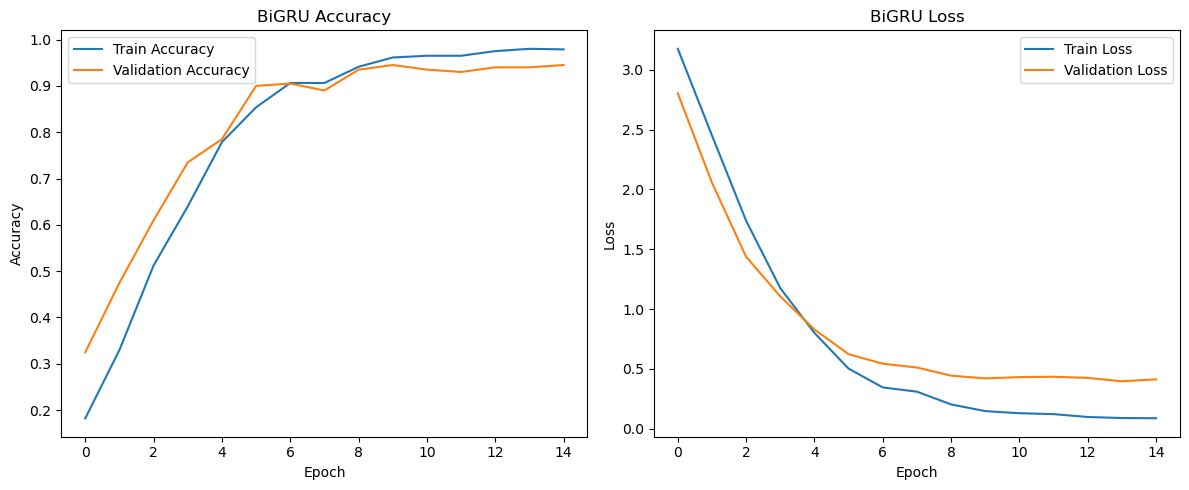

INFO:tensorflow:Assets written to: saved_models/BiGRU/assets


INFO:tensorflow:Assets written to: saved_models/BiGRU/assets


Model saved at: saved_models/BiGRU
          Train                    Validation                   
           Loss Accuracy  F1-Score       Loss Accuracy  F1-Score
Model                                                           
BiGRU  0.086483  0.97875  0.993523   0.411355    0.945  0.992288
7/7 [==============================] - 1s 16ms/step
Best Model: BiGRU
Accuracy: 0.945
Recall: 0.9446496989600439
Precision: 0.9314244663382594
F1-Score: 0.9308063562626722
Confusion Matrix:
[[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  7  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0  0  0  1  0  0  0  0  0

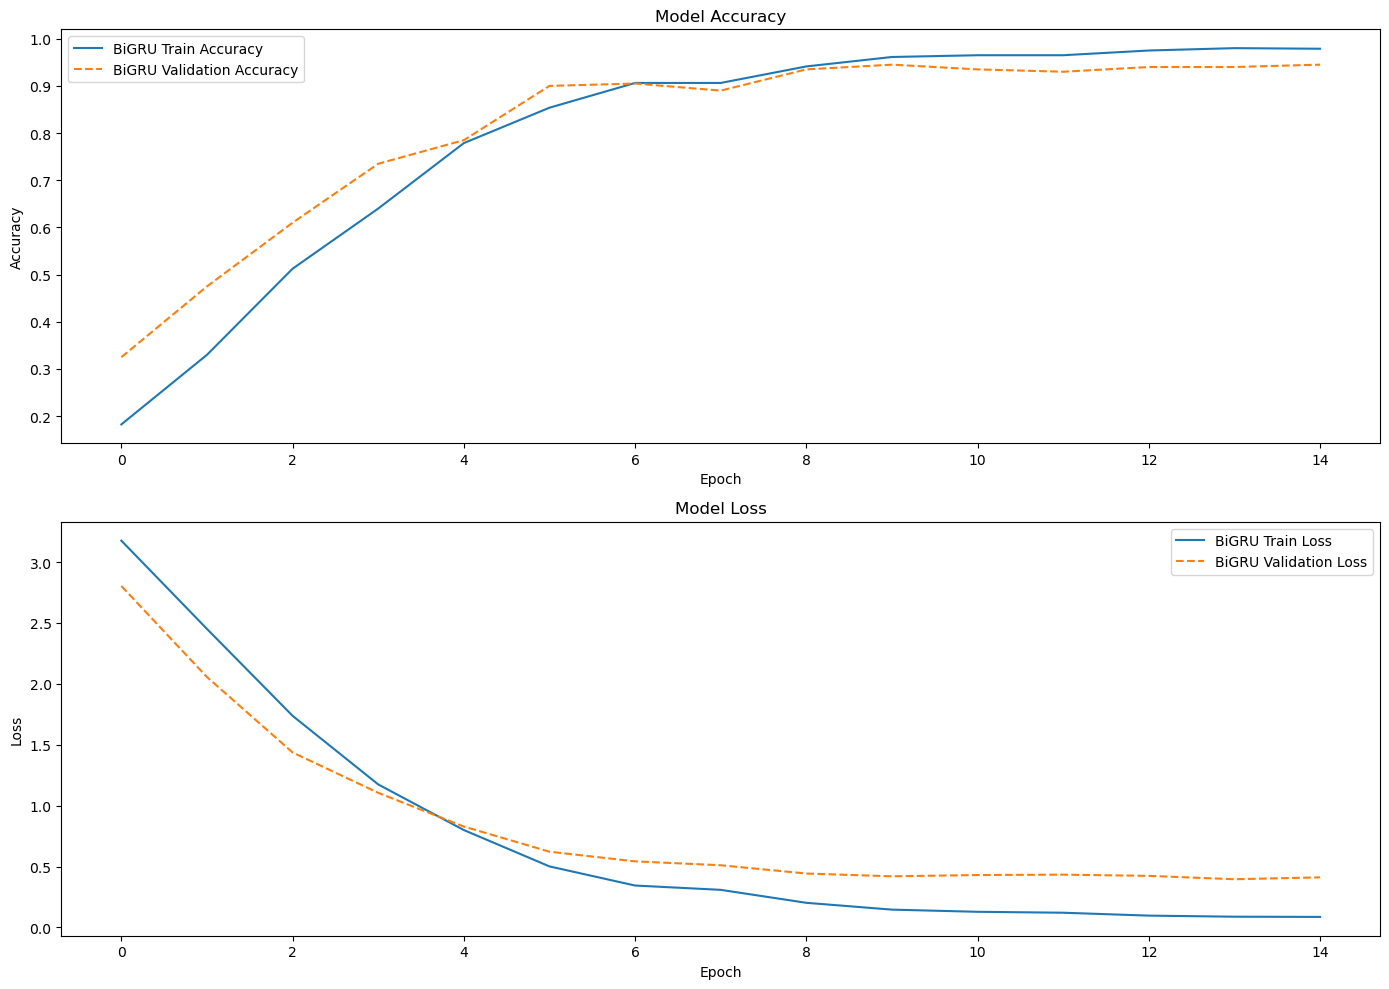

In [17]:
# Model parameters for TensorFlow models
vocab_size = 50_000
embedding_dim = 100
max_length = 128
patience = 3  # Early stopping patience
batch_size = 8  # Batch size
num_epochs = 15  # Number of epochs
random_state = 123
test_size= 0.2
sample_size = 1_000

# Sample and prepare the data
df = df.sample(sample_size, random_state=random_state)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['diagnostico'])
sequences = tokenizer.texts_to_sequences(df['diagnostico'])
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
labels = df['codigo'].astype('category').cat.codes
num_classes = len(np.unique(labels))


# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, 
                                                    test_size=test_size, 
                                                    random_state=random_state)

# Define F1-score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to labels
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.reshape(y_true, [-1])
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define and compile models with additional layers, neurons, dropout, and new metrics
models = {
    'MLP': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ]),
    'CNN': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ]),
    'LSTM': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(256, return_sequences=True),
        Dropout(0.5),
        LSTM(128),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    'BiGRU': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(GRU(64)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
}

# Directory for saving models and plots
model_dir = 'saved_models'
plot_dir = 'model_plots'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Train, evaluate, and save each model
histories = {}
evaluation_results = []

for model_name, model in models.items():
    if 'BiGRU' in model_name:
        print(f"Training {model_name}")
        model.compile(
            loss=SparseCategoricalCrossentropy(),
            optimizer=legacy.Adam(lr=0.001),  # Reduced learning rate
            metrics=['accuracy',F1Score()]
        )
        history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))
        histories[model_name] = history
        results = model.evaluate(X_test, y_test)
        print(f"{model_name} - Results: {results}")
        
        # Extract evaluation metrics
        train_f1 = history.history['f1_score'][-1]
        val_f1 = history.history['val_f1_score'][-1]
        final_loss = history.history['loss'][-1]
        final_accuracy = history.history['accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        
        evaluation_results.append({
            'Model': model_name,
            'Train Loss': final_loss,
            'Train Accuracy': final_accuracy,
            'Train F1-Score': train_f1,
            'Validation Loss': val_loss,
            'Validation Accuracy': val_accuracy,
            'Validation F1-Score': val_f1
        })

        # Plot and save accuracy and loss figures
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        # Save the plot before showing it
        plot_path = os.path.join(plot_dir, f'{model_name}_plot.png')
        plt.savefig(plot_path)
        print(f"Plot saved at: {plot_path}")
        plt.show()

        # Save the model
        model_path = os.path.join(model_dir, model_name)
        model.save(model_path)
        print(f"Model saved at: {model_path}")

# Convert the results to a DataFrame with multi-index columns
results_df = pd.DataFrame(evaluation_results)
results_df.set_index('Model', inplace=True)
results_df.columns = pd.MultiIndex.from_tuples(
    [('Train', 'Loss'), ('Train', 'Accuracy'), ('Train', 'F1-Score'),
    ('Validation', 'Loss'), ('Validation', 'Accuracy'), ('Validation', 'F1-Score')]
)

# Sort by Validation Accuracy
results_df = results_df.sort_values(by=('Validation', 'Accuracy'), ascending=False)
print(results_df)

# Load the best model
best_model_name = results_df.index[0]
best_model_path = os.path.join(model_dir, best_model_name)
best_model = load_model(best_model_path, custom_objects={'F1Score': F1Score})

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Return statistics
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes, average='macro')
precision = precision_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_report = classification_report(y_test, y_pred_classes)

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# Combined plot
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.subplot(2, 1, 1)
for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 1, 2)
for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{model_name} Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'combined_plot.png'))
plt.show()


In [18]:

# Load the best model (assuming best model directory path is known)
best_model_path = 'saved_models/BiGRU/'
best_model = load_model(best_model_path, custom_objects={'F1Score': F1Score})


In [19]:
df_predict = pd.DataFrame(
  {'diag':
   ['el paciente que murio por diabetes mellitus habia llegado con con dolor de cabeza',
    'el niño murio por cancer pero tambien sufrio de lesiones',
    'murio por hipertension pero tambien sufria de asma',
    'tenia neumonia severa y dolor de cabeza',
    'causa indeterminada',
    ]
    })


new_sequences = tokenizer.texts_to_sequences(df_predict['diag'])

new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')

predictions = best_model.predict(new_padded_sequences)

predicted_classes = np.argmax(predictions, axis=1)

category_mapping = dict(enumerate(df['codigo'].astype('category').cat.categories))

predicted_labels = [category_mapping[code] for code in predicted_classes]

df_predict['Predicted Label'] = predicted_labels
df_predict

1/1 [==============================] - 2s 2s/step


,diag,Predicted Label
0,el paciente que murio por diabetes mellitus ha...,j81x
1,el niño murio por cancer pero tambien sufrio d...,k922
2,murio por hipertension pero tambien sufria de ...,s069
3,tenia neumonia severa y dolor de cabeza,j189
4,causa indeterminada,r570


In [20]:
def prediccion(causa):
  tdf = pd.DataFrame({'diag':[causa]})
  seq = tokenizer.texts_to_sequences(tdf['diag'])
  pad = pad_sequences(seq, maxlen=max_length, padding='post')
  pred = best_model.predict(pad)
  icls = np.argmax(pred, axis=1)
  clase = [category_mapping[y] for y in icls]

  return clase[0]

In [21]:
causa = input("Escribe la razon: ")
prediccion(causa)
print(causa)

1/1 [==============================] - 2s 2s/step
diabetes


In [22]:
prediccion(causa)

1/1 [==============================] - 0s 18ms/step


'e149'